In [96]:
import tensorflow as tf
from keras.models import load_model
from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
import numpy as np 
from skimage.measure import compare_ssim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import pickle
import time
import keras

In [2]:
np.random.seed(0)

In [3]:
INDIVIDUALS = 50
P_CROSS = 0.6
P_MUTATION = 0.1
LEN = 784

In [98]:
def euclidean(s):
    # https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

def euc_fitness(individual, target, pred, label, l1=0.5, l2=0.5, N = 50, n_classes=10):
    # petras fitness fucntion
    #print(l1*euclidean(individual-target)/N, l2*euclidean(pred-label)/n_classes)
    return -(l1*euclidean(individual-target)/N + l2*euclidean(pred-label)/n_classes)

def computing_SSIM(individual,target):
    (score, diff) = compare_ssim(individual, target, full=True)
    #diff = (diff * 255).astype("uint8")
    return score

def ssim_fitness(individual, target, pred, label, l1=0.5, l2=0.5, N = 50, n_classes=10):
    return -(l1*computing_SSIM(individual,target)/N + l2*computing_SSIM(pred,label)/n_classes)

def pop_fitness(pop, target, predictions, label):
    return [ssim_fitness(p, target, pred, label) for p, pred in zip(pop, predictions)]

def flatten(imgs):
    # flatten all images in np array or list
    return np.array([im.flatten() for im in imgs])

def gaussian_noise():
    # draw one sample of noise from zero mean 1 variance Gaussian
    return np.random.normal(0, np.sqrt(0.1))

def p_noise(x):
    # add noise given probability
    if P_MUTATION > np.random.uniform():
          return x + gaussian_noise()
    else:
        return x

def add_noise(image):
    # np.random.normal(0, np.sqrt(0.1), (LEN)) 
    # define vectorized function to apply to image
    noise_v = np.vectorize(p_noise)
    return noise_v(image)

def k_crossover(im1, im2, k=2):
    c1, c2 = [], []
    # get k crossover points
    points = sorted([np.random.randint(0, 783, 1) for p in range(k)])
    im_1_split = np.split(im1, [int(p) for p in points])
    im_2_split = np.split(im2, [int(p) for p in points])
    
    # alternate between lists to realise crossover (theres got to be a more clever way to do this)
    for i in range(k+1):
        if i % 2 == 0:
            c1.append(im_1_split[i])
            c2.append(im_2_split[i])
        else:
            c1.append(im_2_split[i])
            c2.append(im_1_split[i])
    return np.concatenate(c1, axis=0), np.concatenate(c2, axis=0)

def tournament(pop, predictions, ground_truth, target, k=3):
    indices = np.random.choice(range(len(pop)), k, replace=False)
    individuals = pop.take(indices)
    scores = [euc_fitness(ind, ground_truth, p, target) for ind ,p in zip(individuals, predictions)]
    index_min = max(range(len(scores)), key=scores.__getitem__)
    return pop[index_min]

def check_adverserial(pop, gt, preds, target, N=50):
    for ind, pred in zip(pop, preds):
        if pred == target and euclidean(ind-gt)/N < 0.01:
            print('WELL HEY THERE')
            return ind
    return None

def init_pop_from_sample(n, num, data, labels):
    indices = np.where(labels==num)[0]
    index = np.random.choice(indices, 1)
    sample = np.take(data, index, axis=0)
    x = np.array([add_noise(sample) for i in range(n)])
    return x.reshape(n, 784), sample

def save_model(model, filename='SVC_model.sav'):
    pickle.dump(model, open(filename, 'wb'))
    
def load_model(filename='SVC_model.sav'):
    return pickle.load(open(filename, 'rb'))

In [81]:
# load flatten and normalize mnist
(x_train, y), (x_test, y_t) = tf.keras.datasets.mnist.load_data()
X = flatten(x_train)
X_t = flatten(x_test)
#X = np.array([x/255 for x in X])
#X_t = np.array([x/255 for x in X_t])

In [91]:
#svm = SVC(C=1, kernel='rbf')
#svm.fit(X, y)
#svm.score(X_t, y_t)
#save_model(svm)
#model = load_model()
#model.score(X_t, y_t)

0.9792

In [43]:
inp = Input(shape=(28,28,1))
conv1 = Conv2D(32, (3,3),activation='relu')(inp)
conv2 = Conv2D(32, (3,3),activation='relu')(conv1)
max_pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop = Dropout(0.25)(max_pool1)
flat =  Flatten()(drop)
dense1 = Dense(128,activation="relu")(flat)
drop = Dropout(0.5)(dense1)
predictions = Dense(10,activation="softmax")(drop)
model = Model(inputs=[inp], outputs=[predictions])
model.compile(optimizer='Adadelta', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [44]:
model.load_weights('CNN_MNIST.h5')
print(model)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               5899

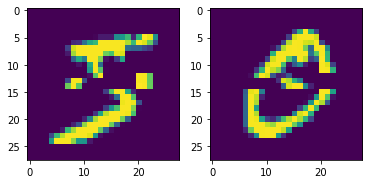

In [14]:
# Examples of crossover
v, w = k_crossover(X[0],X[1])
fig, ax = plt.subplots(1,2)
ax[0].imshow(v.reshape(28,28)) 
ax[1].imshow(w.reshape(28,28))

-0.07175700400237088


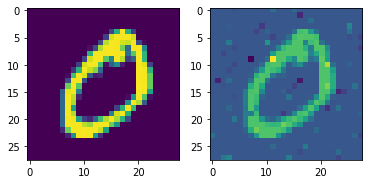

In [17]:
# examples of noise
fig, ax = plt.subplots(1,2)
orig = X[1].reshape(28,28)
example = add_noise(X[1]).reshape(28,28)
ax[0].imshow(orig) 
ax[1].imshow(example)
print(euc_fitness(example, orig, 0, 1))

In [100]:
def ga(num, data, labels, target, max_gen=1000, individuals = INDIVIDUALS, p_cross = P_CROSS, p_mut = P_MUTATION):
    
    # initialize population by drawing 1 sample from passed dataset, automatically applies noise to all copies
    # Then take predictions to calculate population fitness
    pop, ground_truth = init_pop_from_sample(individuals, num, data, labels)
    ground_truth = ground_truth.reshape(784,)
    predictions = np.argmax(model.predict(pop.reshape(individuals, 28,28,1)/255.), axis=1)
    fit_vals = pop_fitness(pop, ground_truth, predictions, target)


    for gen in range(max_gen):
        if gen % 10 == 0:
            print(f'fitting gen: {gen}')
            print('\n predictions:')
            print(predictions)
            print('\n fitness values:')
            print(fit_vals)
            print(f'\n best fitness: {max(fit_vals)}')

        adverserial = check_adverserial(pop, ground_truth, predictions, target)
        if adverserial:
            return adverserial
        
        new_pop = []
        for i in range(individuals//2):
                            
            parent1 = tournament(pop, predictions, ground_truth, target) 
            parent2 = tournament(pop, predictions, ground_truth, target)
            if p_cross > np.random.uniform(0.0, 1.0):
                
                child1, child2 = k_crossover(parent1, parent2) # crossover
                child1, child2 = add_noise(child1), add_noise(child2) # apply mutation to pixels     
                new_pop.append(child1)
                new_pop.append(child2)
            else:
                parent1, parent2 = add_noise(parent1), add_noise(parent2) # apply mutation to pixels     
                new_pop.append(parent1)
                new_pop.append(parent2)
                
        pop = np.array(new_pop)
        predictions = np.argmax(model.predict(pop.reshape(individuals, 28,28,1)/255.), axis=1)

        fit_vals = pop_fitness(pop, ground_truth, predictions, target)
    return pop[fit_vals.index(max(fit_vals))]
    
start = time.process_time()
adverserial = ga(num=1, data=X, labels=y, target=2, max_gen=2000)
print(time.process_time() - start)

(784,) (784,)


C:\Users\Cyril de Kock\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  if sys.path[0] == '':
C:\Users\Cyril de Kock\Anaconda3\lib\site-packages\skimage\measure\_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


AttributeError: 'int' object has no attribute 'shape'

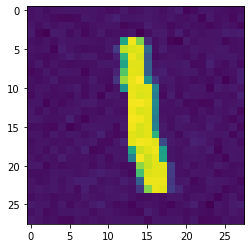

In [93]:
plt.imshow(adverserial.reshape(28,28))

In [85]:
model.predict(adverserial.reshape(1,-1))

array([5], dtype=uint8)

In [ ]:
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, typecode="d", fitness=creator.FitnessMax, strategy=None)
creator.create("Strategy", np.ndarray, typecode="d")

tbx = base.Toolbox()
INDIVIDUAL_SIZE = 784


tbx.register("attr_int", random.randint, 0, 1)
tbx.register("individual", 
             tools.initRepeat, 
             creator.Individual,
             tbx.attr_int, 
             n=INDIVIDUAL_SIZE)
tbx.register("population", tools.initRepeat, list, tbx.individual)
tbx.register("evaluate", EOQ)
tbx.register("mate", tools.cxOnePoint)
tbx.register("mutate", tools.mutFlipBit, indpb=0.01)
tbx.register("select", tools.selTournament, tournsize=5)